# Felix prototype
**Version 0**   
**Date 21/10/2018**  
  
Model used : **Random Forest** Classifier on features selected through **lasso**  
Clustering method used : **Hierarchical clustering** using **ward metric** based on 6 **NOT variable** 

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample

In [2]:
path_project = Path.home() / Path('Google Drive/Felix')
path_data = path_project / Path("data")
path_dump = path_project / Path("dump")

In [3]:
# loading data
file = path_data / Path("dataset.csv")
with Path.open(file, 'rb') as fp:
    dataset = pd.read_csv(fp,  encoding='utf-8',low_memory=False, index_col = 0)

### Features scope and selection strategy  
Features are selected using lasso on the full scope of feature.
The 50 more important features (logistic regression coef ranking) are kept regardless of their activability

In [4]:
# load feature sets
filename = path_dump / Path("dict_features_sets.sav")
with open(filename, 'rb') as fp:
     dict_features_sets = pickle.load(fp)

usual_common_features = dict_features_sets['usual_common_features']
cdv_actionable_individual_1_features = dict_features_sets['cdv_actionable_individual_1_features']
cdv_actionable_individual_2_features = dict_features_sets['cdv_actionable_individual_2_features']
RFE_LogisticRegression_50_features = dict_features_sets['RFE_LogisticRegression_50_features']

In [5]:
print("The 50 most important features obtained using lasso:")
print(list(RFE_LogisticRegression_50_features))

The 50 most important features obtained using lasso:
['CONFENTR', 'TRAVFEM_Elles devraient travailler quand elles le désirent', 'SOUFFNER_Oui', 'PROGRAD_nan', 'CLASSESO_La classe populaire', 'RE_VAC_nan', 'RE_ALIM_nan', 'PREOTENS_Oui', 'NOT_AMIS', 'SOUFFDEP_Oui', 'VACANCES_Oui', 'ETATSAN', 'UDA10_DOM', 'NB03_2_Oui, enfant de moins de 3 ans', 'NOT_LIBR', 'NOT_PROF', 'CLASSESO_Les défavorisés', 'CHOIXNUC_Sans avis', 'INQAGRE3_Non inquiet', 'revtot7', 'CADVIE', 'INQCHOMA', 'NBENF6', 'RE_MEDI_Oui', 'CLASSESO_La classe moyenne supérieure', 'CDV5', 'RE_LOG_Oui', 'RE_EQUI_[Nsp]', 'INQALIM', 'ASSO10_2_Non adhérent', 'RE_ALIM_Oui', 'INQMALAD', 'INQCHOM3_Non inquiet', 'NIVPERSO', 'SOUFFINS_Oui', 'PCSENQ10_Ouvrier', 'CHERCHEM_Oui', 'NBCHOM', 'RE_VOIT_Oui', 'OPIRSA_[Nsp]', 'BANQEPA_Oui', 'HANDICAP_Oui', 'OPIIMMIG_[Nsp]', 'zau2010_nan', 'LIEN_2_Conjoint ou compagnon', 'SITUEMP3_Inactif', 'NOT_FAMI', 'SECURITE', 'STATMAT4_En ménage, marié', 'SITUFAM_Couple sans enfants']


### Clustering method - feature used 
Hierarchical clustering is used using 6 common "NOT_" variable

In [6]:
# loading clustering
file = path_data / Path("clustTest3.csv")
with Path.open(file, 'rb') as fp:
    clustTest1 = pd.read_csv(fp,  encoding='utf-8',low_memory=False, sep=";", index_col = 0)

### Training set and test set preparation

In [7]:
df = dataset.loc[:,:]
# reducing problem to a 2 class classification problem
df["HEUREUX_CLF"] = 0
df.loc[df["HEUREUX"]==4, "HEUREUX_CLF"] = 1
df.loc[df["HEUREUX"]==3, "HEUREUX_CLF"] = 1
df.loc[df["HEUREUX"]==5, "HEUREUX_CLF"] = None

scope = ( RFE_LogisticRegression_50_features  )  & set(dataset.columns)
n_max = 2000

df = df.loc[:,scope | {"HEUREUX_CLF"} ].dropna()
features = df.loc[:,scope ].columns

X = df.loc[:,scope]
y = df["HEUREUX_CLF"]


Xs, ys = resample(X, y, random_state=42)

Xs = Xs.iloc[0:n_max,:]
ys = ys.iloc[0:n_max]

X_train, X_test, y_train, y_test = train_test_split(Xs, ys, 
                                                    test_size=0.2, 
                                                    random_state=42
                                                   )

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(f"Number exemple: {y.shape[0]}\n- training set: \
{y_train.shape[0]}\n- test set: {y_test.shape[0]}")
print(f"Number of features: p={X_train.shape[1]}")
print(f"Number of class: {len(np.unique(y))}")
for c in np.unique(y):
    print(f"class {c:0.0f} : {100*np.sum(y==c)/len(y):0.1f}%")

Number exemple: 10788
- training set: 1600
- test set: 400
Number of features: p=50
Number of class: 2
class 0 : 35.0%
class 1 : 65.0%


### Learning and model performance evaluation on full dataset (before clustering)


In [8]:
startTime = time.time()
n_estimators_range = [32,64,128,256,512]
max_depth_range = [4,8,16,32,64] 
param_grid = dict(n_estimators=n_estimators_range, max_depth = max_depth_range)

params = {'max_features' :'sqrt', 'random_state' : 32,
          'min_samples_split' : 2, 'class_weight' : 'balanced'}
clf = RandomForestClassifier(**params)

grid = GridSearchCV(clf, scoring='accuracy', param_grid=param_grid)
grid.fit(X_train, y_train)
print(f"Determination of optimal hyperparameters in {time.time() - startTime:0.1f} s")
print(f"Optimal values are {grid.best_params_} \n\
Accuracy Score of cross valdation {100*grid.best_score_:0.2f}%")

# Learning on full training set with optimals hyperparameters and score on test set
params = {'max_features' :'sqrt', 'random_state' : 32, 
          'min_samples_split' : 2, 'class_weight' : 'balanced',
          'n_estimators' : grid.best_params_['n_estimators'],
          'max_depth' : grid.best_params_['max_depth']}
clf = RandomForestClassifier(**params).fit(X_train, y_train)
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)

print(f"Random Forest, p={X_train.shape[1]}")
accuracy = clf.score(X_test, y_test)
f1 = f1_score(y_test, y_test_pred)
p = precision_score(y_test, y_test_pred)
r = recall_score(y_test, y_test_pred)
print(f"Model score\n- Accuracy : {accuracy*100:0.1f} %")
print(f"- Precision : {p*100:0.1f} % (Happy # positive class)")
print(f"- Recall : {r*100:0.1f} %")
print(f"- F1 score : {f1*100:0.1f} %")
res_full  = {
    'f1_score' : f1,
    'accuracy' : accuracy,
    'precision' : p,
    'recall' : r
}

Determination of optimal hyperparameters in 48.0 s
Optimal values are {'max_depth': 32, 'n_estimators': 256} 
Accuracy Score of cross valdation 76.12%
Random Forest, p=50
Model score
- Accuracy : 73.2 %
- Precision : 73.7 % (Happy # positive class)
- Recall : 89.7 %
- F1 score : 80.9 %


Feature ranking:
1. feature 19 -revtot7- (0.057628)
	Actionable at individual level (2)
2. feature 15 -NOT_PROF- (0.045291)
	Actionable at individual level (1)
3. feature 9 -NOT_AMIS- (0.044856)
	Actionable at individual level (1)
4. feature 33 -NIVPERSO- (0.037919)
	Actionable at individual level (2)
5. feature 14 -NOT_LIBR- (0.037460)
	Actionable at individual level (1)
6. feature 25 -CDV5- (0.035741)
	Actionable at individual level (2)
7. feature 22 -NBENF6- (0.035219)
	Actionable at individual level (2)
8. feature 10 -SOUFFDEP_Oui- (0.035098)
	Actionable at individual level (2)
9. feature 20 -CADVIE- (0.034076)
	Actionable at individual level (1)
10. feature 49 -ETATSAN- (0.033789)
	Actionable at individual level (1)
11. feature 28 -INQALIM- (0.033493)
	Actionable at individual level (1)
12. feature 46 -NOT_FAMI- (0.033475)
	Actionable at individual level (1)
13. feature 0 -CONFENTR- (0.031363)
	Actionable at individual level (1)
14. feature 47 -SECURITE- (0.030271)
	Actionable at 

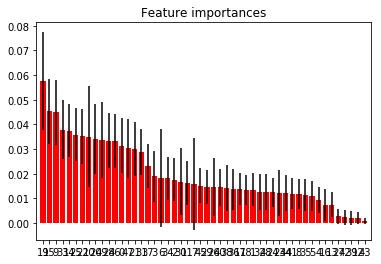

In [9]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
features_name = np.array(features)
#features_name_sorted_rf = features_name[indices]
# Print the feature ranking
print("Feature ranking:")

max_features = 15

for f in range(min(X.shape[1],max_features)):
    print("%d. feature %d -%s- (%f)" % (f + 1, indices[f],features_name[indices[f]], importances[indices[f]]))
    if features_name[indices[f]] in cdv_actionable_individual_1_features:
        print("\tActionable at individual level (1)")
    elif features_name[indices[f]] in cdv_actionable_individual_2_features:
        print("\tActionable at individual level (2)")

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

### Learning and model performance evaluation on each clusters

In [10]:
n_estimators_range = [16,32,64,128]
max_depth_range = [2,4,8,16,32,64] 
param_grid = dict(n_estimators=n_estimators_range, max_depth = max_depth_range)
params = {'max_features' :'sqrt', 
          'random_state' : 32, 
          'min_samples_split' : 2, 
          'class_weight' : 'balanced'
         }
scope = ( RFE_LogisticRegression_50_features )  & set(dataset.columns)
features = df.loc[:,scope].columns

In [11]:
score_clustering_methods = []
clustering_methods = clustTest1.columns[2:3]

for method in clustering_methods:
    print("--------------------------------------------")
    print(f"\nAnalysis cluster method {method}")
    cluster_list = clustTest1[method].unique()
    print(f"liste of clusters : {cluster_list}")
    score_cluster = []
    for cluster in cluster_list:
        index_scope = clustTest1.loc[clustTest1[method]==cluster,:].index
        print(f"cluster {cluster} : {len(index_scope)} elements")
        
        Xc = X.loc[index_scope.intersection(X.index),:]
        yc = y[index_scope.intersection(X.index)]
        
        Xs, ys = resample(Xc, yc, random_state=42)
        
        Xs = Xs.iloc[0:n_max,:]
        ys = ys.iloc[0:n_max]
        
        X_train, X_test, y_train, y_test = train_test_split(Xs, ys,
                                                            test_size=0.2, 
                                                            random_state=42)

        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
                
        print(f"Number exemple: {ys.shape[0]}\n\
        - training set: {y_train.shape[0]}\n\
        - test set: {y_test.shape[0]}")
        print(f"Number of features: p={X_train.shape[1]}")
        print(f"Number of class: {len(np.unique(y))}")
        for c in np.unique(y):
            print(f"class {c:0.0f} : {100*np.sum(y==c)/len(y):0.1f}%")
            
            
        startTime = time.time()
        clf = RandomForestClassifier(**params)
        grid = GridSearchCV(clf, 
                            scoring='accuracy', 
                            param_grid=param_grid)

        grid.fit(X_train, y_train)
        print(f"Optimal values are {grid.best_params_} \n\
cross validation score {100*grid.best_score_:0.2f}%")
        print()

        # Learning on full training set with optimals hyperparameters and score on test set
        params_opt = {'max_features' :'sqrt', 'random_state' : 32, 
                      'min_samples_split' : 2, 'class_weight' : 'balanced',
                      'n_estimators' : grid.best_params_['n_estimators'],
                      'max_depth' : grid.best_params_['max_depth']}
        clf = RandomForestClassifier(**params_opt).fit(X_train, y_train)

            
        y_test_pred = clf.predict(X_test)
        accuracy = clf.score(X_test, y_test)
        f1 = f1_score(y_test, y_test_pred)
        p = precision_score(y_test, y_test_pred)
        r = recall_score(y_test, y_test_pred)            

        res  = {'f1_score' : f1,
                'accuracy' : accuracy,
                'precision' : p,
                'recall' : r}
            
        cl = {'cluster' : cluster,
              'size' : len(index_scope),
              'model' : 'RandomForestClassifier',
              'params' : params_opt,
              'metrics' : res
             }
         
        score_cluster.append(cl)
        
    d = {'clustering_method' : method,
         'cluster_scores' : score_cluster
        }
    score_clustering_methods.append(d) 

--------------------------------------------

Analysis cluster method clust3
liste of clusters : [2 4 6 1 3 5]
cluster 2 : 3053 elements
Number exemple: 2000
        - training set: 1600
        - test set: 400
Number of features: p=50
Number of class: 2
class 0 : 35.0%
class 1 : 65.0%
Optimal values are {'max_depth': 16, 'n_estimators': 128} 
cross validation score 80.75%

cluster 4 : 2359 elements
Number exemple: 2000
        - training set: 1600
        - test set: 400
Number of features: p=50
Number of class: 2
class 0 : 35.0%
class 1 : 65.0%
Optimal values are {'max_depth': 16, 'n_estimators': 128} 
cross validation score 84.06%

cluster 6 : 2313 elements
Number exemple: 2000
        - training set: 1600
        - test set: 400
Number of features: p=50
Number of class: 2
class 0 : 35.0%
class 1 : 65.0%
Optimal values are {'max_depth': 32, 'n_estimators': 32} 
cross validation score 82.75%

cluster 1 : 528 elements
Number exemple: 505
        - training set: 404
        - test set:

### Performance gain obtained using clustering

In [12]:
# F1 score
for score_method in score_clustering_methods:
    print(f"method {score_method['clustering_method']}:")
    average_score = 0
    total_size = 0
    for i, score_cluster in enumerate(score_method['cluster_scores']):
        print(f"cluster {score_cluster['cluster']} ({score_cluster['size']}), f1 macro {100*score_cluster['metrics']['f1_score']:0.1f}%")  
        average_score += score_cluster['metrics']['f1_score']*score_cluster['size']
        total_size += score_cluster['size']
        
    average_score = average_score / total_size
    print(f"average f1 on clusters {100*average_score:0.1f}% gain {100*(average_score-res_full['f1_score']):0.1f}\n")  

method clust3:
cluster 2 (3053), f1 macro 88.8%
cluster 4 (2359), f1 macro 92.9%
cluster 6 (2313), f1 macro 93.0%
cluster 1 (528), f1 macro 89.1%
cluster 3 (1384), f1 macro 92.3%
cluster 5 (1494), f1 macro 87.7%
average f1 on clusters 90.8% gain 9.9



In [13]:
# accuracy
for score_method in score_clustering_methods:
    print(f"method {score_method['clustering_method']}:")
    average_score = 0
    total_size = 0
    for i, score_cluster in enumerate(score_method['cluster_scores']):
        print(f"cluster {score_cluster['cluster']} ({score_cluster['size']}) , accuracy {100*score_cluster['metrics']['accuracy']:0.1f}%")  
        average_score = average_score + score_cluster['metrics']['accuracy']*score_cluster['size']
        total_size += score_cluster['size']
    average_score = average_score / total_size
    print(f"average accuracy on clusters {100*average_score:0.1f}% gain {100*(average_score-res_full['accuracy']):0.1f}\n")  

method clust3:
cluster 2 (3053) , accuracy 84.2%
cluster 4 (2359) , accuracy 89.5%
cluster 6 (2313) , accuracy 89.8%
cluster 1 (528) , accuracy 90.1%
cluster 3 (1384) , accuracy 88.7%
cluster 5 (1494) , accuracy 85.4%
average accuracy on clusters 87.5% gain 14.2



### Feature importance of the models & actionable variables